In [6]:
# imports and loading
from pymodulon.io import *
from pymodulon.plotting import *
from scipy.stats import fisher_exact, chi2_contingency
from statsmodels.stats.multitest import multipletests
from os import path
import seaborn as sns

data_dir = path.join('..','data','processed_data')
interim_dir = path.join('..','data','interim')
ica_data = load_json_model(path.join(interim_dir,'zmo_raw.json.gz'))

# let's create a metadata enrichment function
def metadata_enrichment(ica_data, iM, categories = ['project','gene_KO', 'Strain Description', 'Evolved Sample', 'Base Media', 'Temperature (C)', 'pH', 'Carbon Source (g/L)', 'Supplement', 'Growth Rate (1/hr)', 'Isolate Type', 'lab', 'Aerobicity']):
    # first let's find the samples where the iM is active
    vals = abs(ica_data.A.loc[iM].values)
    avg = np.mean(vals)
    std = np.std(vals)
    active_samps = ica_data.A.columns[vals > (avg + 2*std)]
    samp_table = ica_data.sample_table.fillna('nan')
    samp_table['is_active'] = samp_table.index.isin(active_samps)
    
    # now enrichment against the categories
    return_dfs = []
    for cat in categories:
        # try each type of category found in the active samples
        contingency_table = pd.crosstab(samp_table[cat], samp_table['is_active'])
        _, pval, dof, expected = chi2_contingency(contingency_table)
        observed = contingency_table.values
        observed_df = pd.DataFrame(observed, index=contingency_table.index, columns=contingency_table.columns)
        residuals = (observed - expected) / (expected ** 0.5)
        residuals_df = pd.DataFrame(residuals, index=contingency_table.index, columns=contingency_table.columns)
        most_abnormal = abs(residuals_df).sort_values(by = True, ascending = False).index[0]
        
        # calculate precision and recall of most abnormal
        true_pos = observed_df.loc[most_abnormal][True]
        false_pos = observed_df.loc[most_abnormal][False]
        false_neg = observed_df[True].sum() - true_pos
        precision = true_pos / (true_pos + false_pos)
        recall = true_pos / (true_pos + false_neg)
        
        return_dfs.append([cat, pval, most_abnormal, precision, recall])
    
    output_df = pd.DataFrame(return_dfs, columns = ['Category', 'p_value', 'most_enriched', 'precision', 'recall'])
    _, q_values, _, _ = multipletests(output_df['p_value'], method='fdr_bh')
    output_df['q_value'] = q_values
    output_df = output_df.set_index('Category').sort_values(by = 'p_value')[['p_value', 'q_value', 'most_enriched', 'precision', 'recall']]
    
    return(output_df)


# gene table enrichment
def genes_enrichment(ica_data, iM, categories = ['strand', 'gene_product', 'COG', 'operon', 'chromosome_id']):
    # first let's find the samples where the iM is active
    vals = abs(ica_data.A.loc[iM].values)
    avg = np.mean(vals)
    std = np.std(vals)
    active_samps = ica_data.view_imodulon(iM).index
    samp_table = ica_data.gene_table.fillna('nan')
    samp_table['is_active'] = samp_table.index.isin(active_samps)
    
    # now enrichment against the categories
    return_dfs = []
    for cat in categories:
        # try each type of category found in the active samples
        contingency_table = pd.crosstab(samp_table[cat], samp_table['is_active'])
        _, pval, dof, expected = chi2_contingency(contingency_table)
        observed = contingency_table.values
        observed_df = pd.DataFrame(observed, index=contingency_table.index, columns=contingency_table.columns)
        residuals = (observed - expected) / (expected ** 0.5)
        residuals_df = pd.DataFrame(residuals, index=contingency_table.index, columns=contingency_table.columns)
        most_abnormal = abs(residuals_df).sort_values(by = True, ascending = False).index[0]
        
        # calculate precision and recall of most abnormal
        true_pos = observed_df.loc[most_abnormal][True]
        false_pos = observed_df.loc[most_abnormal][False]
        false_neg = observed_df[True].sum() - true_pos
        precision = true_pos / (true_pos + false_pos)
        recall = true_pos / (true_pos + false_neg)
        
        return_dfs.append([cat, pval, most_abnormal, precision, recall])
    
    output_df = pd.DataFrame(return_dfs, columns = ['Category', 'p_value', 'most_enriched', 'precision', 'recall'])
    _, q_values, _, _ = multipletests(output_df['p_value'], method='fdr_bh')
    output_df['q_value'] = q_values
    output_df = output_df.set_index('Category').sort_values(by = 'p_value')[['p_value', 'q_value', 'most_enriched', 'precision', 'recall']]
    
    return(output_df)


def custom_plot_gene_weights(ica_data, imodulon, by="start", xaxis=None, xname="", **kwargs):
    """
    Plot gene weights on a scatter plot.

    Parameters
    ----------
    ica_data: ~pymodulon.core.IcaData
        :class:`~pymodulon.core.IcaData` object
    imodulon : int or str
        `iModulon` name
    by: 'log-tpm-norm', 'length', or 'start'
        Property to plot on x-axis. Superceded by `xaxis`
    xaxis: list, dict or ~pandas.Series, optional
        Values on custom x-axis
    xname: str, optional
        Name of x-axis if using custom x-axis
    **kwargs:
        Additional keyword arguments passed to :func:`pymodulon.plotting.scatterplot`
    Returns
    -------
    ax: ~matplotlib.axes.Axes
        :class:`~matplotlib.axes.Axes` containing the scatterplot
    """
    # Check that iModulon exists
    if imodulon in ica_data.M.columns:
        y = ica_data.M[imodulon]
        ylabel = f"{imodulon} Gene Weight"
    else:
        raise ValueError(f"iModulon does not exist: {imodulon}")

    # Get genes in the iModulon
    bin_M = ica_data.M_binarized
    component_genes = set(bin_M[imodulon].loc[bin_M[imodulon] == 1].index)
    other_genes = set(bin_M[imodulon].loc[bin_M[imodulon] == 0].index)

    # If experimental `xaxis` parameter is used, use custom values for x-axis
    if xaxis is not None:
        x = _set_xaxis(xaxis=xaxis, y=y)
        xlabel = xname

    else:
        #  Ensure 'by' has a valid input and assign x, xlabel accordingly
        if by == "log-tpm":
            x = ica_data.log_tpm.mean(axis=1)
            xlabel = "Mean Expression"
        elif by == "log-tpm-norm":
            x = ica_data.X.mean(axis=1)
            xlabel = "Mean Centered Expression"
        elif by == "length":
            x = np.log10(ica_data.gene_table.length)
            xlabel = "Gene Length (log10-scale)"
        elif by == "start":
            x = ica_data.gene_table.start
            xlabel = "Gene Start"
        else:
            raise ValueError(
                '"by" must be "log-tpm", "log-tpm-norm", "length", ' 'or "start"'
            )

    # Override specific kwargs (their implementation is different
    # in this function)
    show_labels_pgw = kwargs.pop("show_labels", "auto")
    adjust_labels_pgw = kwargs.pop("adjust_labels", True)
    legend_kwargs_pgw = kwargs.pop("legend_kwargs", {})
    label_font_kwargs_pgw = kwargs.pop("label_font_kwargs", {})

    kwargs["show_labels"] = kwargs["adjust_labels"] = False

    # Remove xlabel and ylabel kwargs if provided
    kwargs.pop("xlabel", None)
    kwargs.pop("ylabel", None)

    # Default legend should be on the side of the plot
    if (
        "bbox_to_anchor" not in legend_kwargs_pgw.keys()
        and "loc" not in legend_kwargs_pgw.keys()
    ):
        legend_kwargs_pgw.update({"bbox_to_anchor": (1, 1), "loc": 2})
        kwargs["legend_kwargs"] = legend_kwargs_pgw

    # Update colors for COG groups
    if "COG" in ica_data.gene_table.columns and "groups" not in kwargs:
        mod_cogs = ica_data.gene_table.loc[component_genes].COG
        hidden_cogs = pd.Series("hidden", index=other_genes)
        all_cogs = pd.concat([mod_cogs, hidden_cogs])
        # colors = {cog:ica_data.cog_colors[cog] for cog in sorted(mod_cogs.unique())}
        kwargs.update({"groups": all_cogs, "colors": ica_data.cog_colors})

    # Scatter Plot
    ax = scatterplot(x, y, xlabel=xlabel, ylabel=ylabel, **kwargs)
    
    # add vertical lines at chromosome changes
    for grp in ica_data.gene_table.groupby('chromosome_id'):
        plt.axvline(x = max(grp[1].fillna(0).end), ls = '--', c = 'k')

    # Add thresholds to scatter-plot (dashed lines)
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()

    thresh = ica_data.thresholds[imodulon]
    if thresh != 0:
        ax.hlines(
            [thresh, -thresh],
            xmin=xmin,
            xmax=xmax,
            colors="k",
            linestyles="dashed",
            linewidth=1,
        )

    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

    texts = []
    expand_kwargs = {"expand_objects": (1.2, 1.4), "expand_points": (1.3, 1.3)}

    # Add labels: Put gene name if components contain under 20 genes
    if show_labels_pgw is True or (
        show_labels_pgw is not False and len(component_genes) <= 20
    ):
        for gene in component_genes:

            # Add labels
            text_kwargs = label_font_kwargs_pgw.copy()

            if "fontstyle" not in text_kwargs:
                text_kwargs.update({"fontstyle": "normal"})

            # Italicize gene if there is a defined name (not locus tag)
            try:
                gene_name = ica_data.gene_table.loc[gene, "gene_name"]

                if gene_name != gene:
                    text_kwargs.update({"fontstyle": "italic"})

            except KeyError:
                gene_name = gene

            # Set default fontsize
            if "fontsize" not in text_kwargs:
                text_kwargs.update({"fontsize": 12})

            texts.append(
                ax.text(
                    x[gene],
                    ica_data.M.loc[gene, imodulon],
                    gene_name,
                    **text_kwargs,
                )
            )

        expand_kwargs["expand_text"] = (1.4, 1.4)

    # Add labels: Repel texts from other text and points
    rect = ax.add_patch(
        Rectangle(
            xy=(xmin, -abs(thresh)),
            width=xmax - xmin,
            height=2 * abs(thresh),
            fill=False,
            linewidth=0,
        )
    )

    if adjust_labels_pgw:
        adjust_text(
            texts=texts,
            add_objects=[rect],
            ax=ax,
            arrowprops=dict(arrowstyle="-", color="k", lw=0.5),
            only_move={"objects": "y"},
            **expand_kwargs,
        )

    return ax

# investgiate an iM

In [15]:
iM_ct = 'ETC_and_MEP'

In [16]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
impt_cols = ['gene_name', 'gene_weight', 'gene_product', 'COG', 'regulator', 'EC_number', 'interpro_annotation', 'aerobic_essential', 'anaerobic_essential']
df = ica_data.view_imodulon(iM_ct).sort_values(by = 'gene_weight', ascending = False, key = abs)
super_impt_cols = ['gene_weight', 'gene_product', 'COG', 'EC_number']
df#[impt_cols]

,gene_weight,gene_name,accession,start,end,strand,gene_product,COG,regulator,uniprot,operon,kegg_maps,EC_number,ZM4_locus,aerobic_essential,anaerobic_essential,interpro_annotation,anaero_xylose_model_flux,anaero_glucose_model_flux,aero_xylose_model_flux,aero_glucose_model_flux,anaero_xylose_model_growth_perc_change,anaero_glucose_model_growth_perc_change,aero_xylose_model_growth_perc_change,aero_glucose_model_growth_perc_change,chromosome_id,iMs
ZCP4_0579,0.188910,greB,CP006818.1,658964.0,659461.0,+,transcription elongation factor GreB,Transcription,NaN,Q5NPL8,Op695,NaN,NaN,ZMO1_ZMO0718,0.000000,0.000000,C-terminal region of a signal peptide.;Hydroph...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CP006818.1,['ETC_and_MEP']
ZCP4_1365,0.167314,rnfB,CP006818.1,1532535.0,1533197.0,+,electron transport complex%2C RnfABCDGE type%2...,Energy production and conversion,NaN,Q5NLH3,Op1452,NaN,NaN,ZMO1_ZMO1813,0.000000,-4.539192,SignalP-TM;SignalP-noTM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CP006818.1,['ETC_and_MEP']
ZCP4_1364,0.157289,rnfA,CP006818.1,1531937.0,1532518.0,+,electron transport complex%2C RnfABCDGE type%2...,Energy production and conversion,NaN,Q5NLH2,Op1451,NaN,NaN,ZMO1_ZMO1814,0.000000,-4.195910,C-terminal region of a signal peptide.;Hydroph...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CP006818.1,['ETC_and_MEP']
ZCP4_1366,0.152716,ZCP4_1366,CP006818.1,1533208.0,1534671.0,+,electron transport complex%2C RnfABCDGE type%2...,Energy production and conversion,NaN,NaN,Op1453,NaN,NaN,ZMO1_ZMO1812,0.000000,-4.151566,SignalP-TM;SignalP-noTM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CP006818.1,['ETC_and_MEP']
ZCP4_0578,0.146638,ZCP4_0578,CP006818.1,656796.0,658889.0,+,soluble lytic murein transglycosylase-like pro...,Cell wall/membrane/envelope biogenesis,NaN,NaN,Op694,NaN,NaN,ZMO1_ZMO0719,-1.489979,-2.826506,SignalP-TM;SignalP-noTM,0.000000,0.000000,0.000000,0.000000,1.056027e+00,1.056027e+00,1.000000e+00,1.000000e+00,CP006818.1,['ETC_and_MEP']
ZCP4_0259,0.141491,ZCP4_0259,CP006818.1,296809.0,297213.0,-,SufE protein probably involved in Fe-S center ...,Function unknown,NaN,NaN,Op392,NaN,NaN,ZMO1_ZMO1067,-2.175877,0.000000,SignalP-TM;SignalP-noTM,0.000000,0.000000,0.000000,0.000000,1.056027e+00,1.056027e+00,1.000000e+00,1.000000e+00,CP006818.1,['ETC_and_MEP']
ZCP4_0258,0.130503,ZCP4_0258,CP006818.1,296378.0,296812.0,-,hypothetical protein,"Intracellular trafficking, secretion, and vesi...",ZCP4_1194,NaN,Op391,NaN,NaN,ZMO1_ZMO1068,0.000000,0.000000,SignalP-TM;SignalP-noTM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CP006818.1,['ETC_and_MEP']
ZCP4_0096,0.128894,dxs1,CP006818.1,106384.0,108333.0,+,1-deoxy-D-xylulose-5-phosphate synthase,Coenzyme transport and metabolism,NaN,Q5NN52,Op238,map00730;map00900;map01100;map01110;map01130,2.2.1.7,ZMO1_ZMO1598,0.000000,0.000000,SignalP-TM;SignalP-noTM,0.081626,0.080061,0.637009,0.624146,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,CP006818.1,"['ETC_and_MEP', 'noise_5']"
ZCP4_1368,0.118381,rnfG,CP006818.1,1535744.0,1536454.0,+,electron transport complex%2C RnfABCDGE type%2...,Energy production and conversion,NaN,Q5NLH6,Op1455,NaN,NaN,ZMO1_ZMO1810,0.000000,-4.187125,SignalP-TM;SignalP-noTM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CP006818.1,['ETC_and_MEP']
ZCP4_1367,0.117324,rnfD,CP006818.1,1534671.0,1535747.0,+,electron transport complex%2C RnfABCDGE type%2...,Energy production and conversion,NaN,Q5NLH5,Op1454,NaN,1.6.5.8,ZMO1_ZMO1811,0.000000,-4.116082,SignalP-TM;SignalP-noTM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CP006818.1,['ETC_and_MEP']


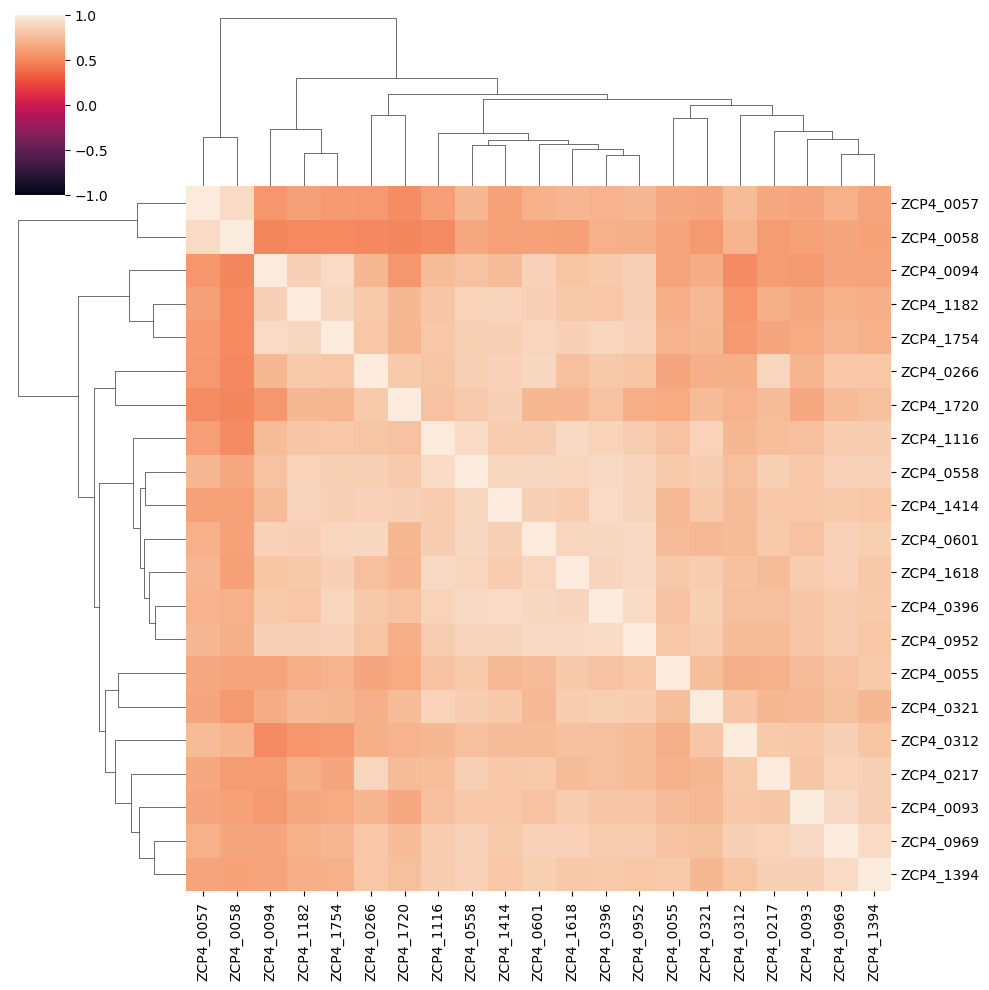

In [9]:
df = ica_data.X.loc[ica_data.view_imodulon(iM_ct).index]
sns.clustermap(df.T.corr(), vmin = -1, vmax = 1)
plt.show()

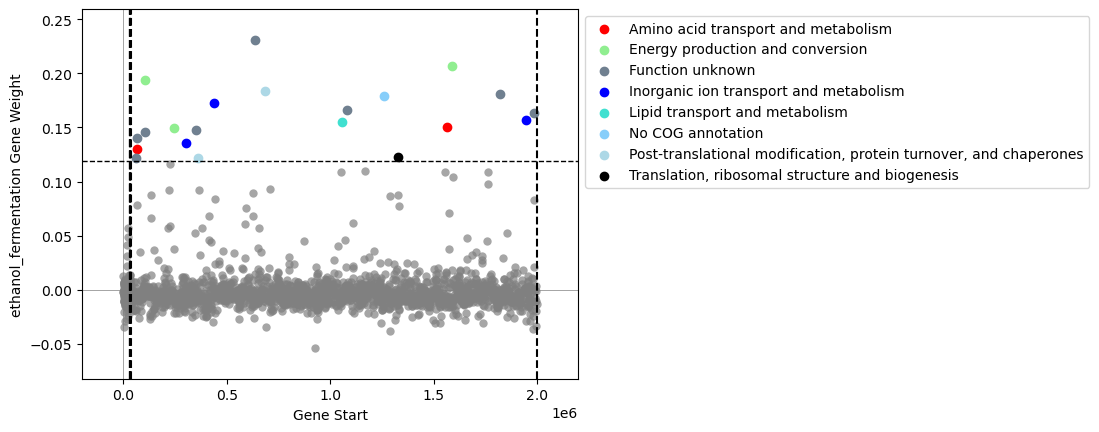

In [10]:
custom_plot_gene_weights(ica_data, iM_ct)
plt.show()

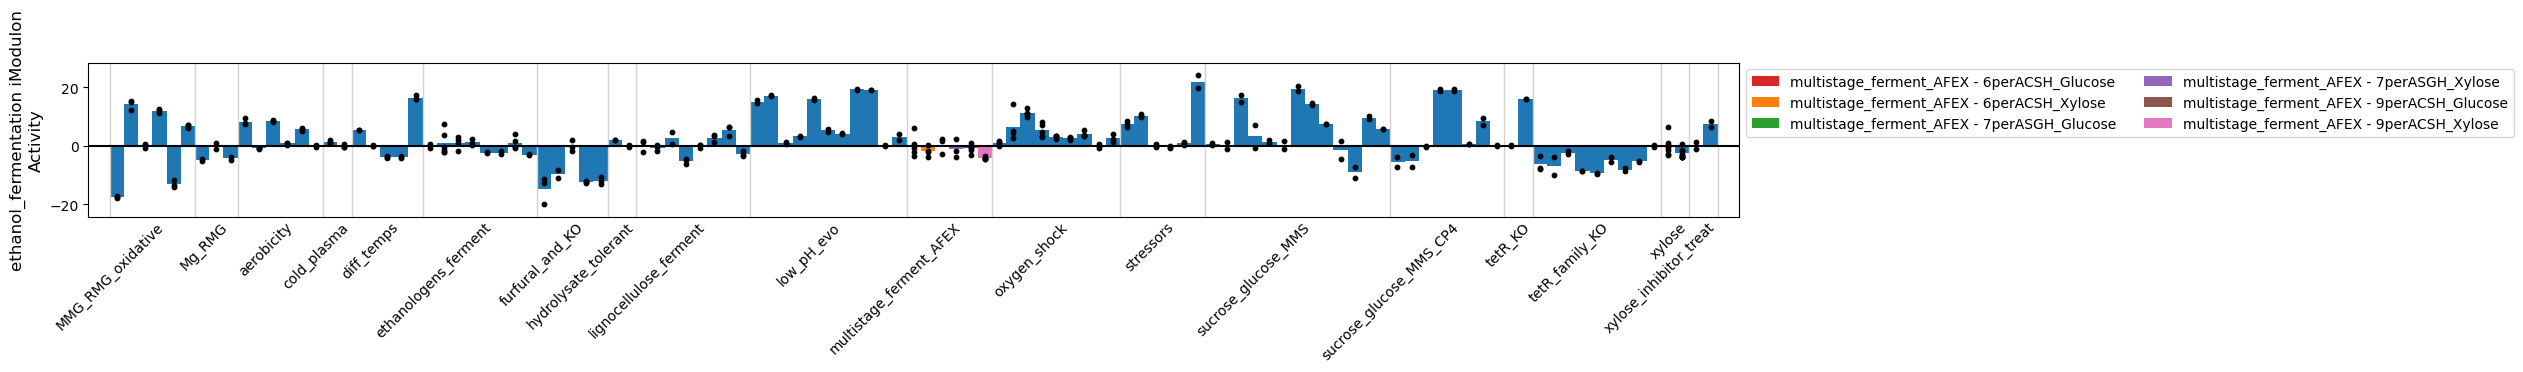

In [11]:
plot_activities(ica_data, iM_ct, highlight=['multistage_ferment_AFEX'])#'low_pH_evo'])
plt.show()

In [12]:
out = metadata_enrichment(ica_data, iM_ct)
out[out['q_value'] < 0.10]

,p_value,q_value,most_enriched,precision,recall
Category,,,,,
pH,4.301394e-14,5.591812e-13,3.8,0.700000,0.333333
Supplement,4.495310e-07,2.921952e-06,MMS (15 mM),1.000000,0.095238
Evolved Sample,9.423823e-06,4.083656e-05,yes,0.318182,0.333333
Isolate Type,2.418104e-05,7.858839e-05,size fractionation,0.318182,0.333333
project,1.314885e-04,3.418701e-04,low_pH_evo,0.318182,0.333333
Growth Rate (1/hr),1.558048e-03,3.375770e-03,OD 1.5 / stationary,1.000000,0.095238
Strain Description,2.143585e-03,3.980943e-03,Zymomonas mobilis subsp. mobilis str. CP4 = NR...,0.250000,0.190476
Temperature (C),1.024664e-02,1.665078e-02,30.0,0.008130,0.047619
Carbon Source (g/L),6.707369e-02,9.688421e-02,glucose(2%),0.184211,0.333333


In [8]:
out = genes_enrichment(ica_data, iM_ct)
out[out['q_value'] < 0.10]

,p_value,q_value,most_enriched,precision,recall
Category,,,,,
gene_product,2.118313e-08,1.059156e-07,ribonucleotide reductase%2C alpha subunit,1.000000,0.04
COG,6.434910e-04,1.608728e-03,Energy production and conversion,0.069307,0.28


# below is as forked from SBRG/iModulonMiner, ignoring it for now

## Add iModulon category

In [ ]:
for i,row in ica_data.imodulon_table.iterrows():
    if pd.notnull(row.regulator):
        ica_data.imodulon_table.loc[i, 'category'] = 'regulatory'
    elif pd.notnull(row.single_gene):
        ica_data.imodulon_table.loc[i, 'category'] = 'single_gene'
    else:
        ica_data.imodulon_table.loc[i, 'category'] = 'uncharacterized'

In [ ]:
ica_data.imodulon_table.head()

## Inspect all iModulons without an automated annotation

In [ ]:
unchar_imods = ica_data.imodulon_table[ica_data.imodulon_table.category == 'uncharacterized']

In [ ]:
unchar_imods

### iModulon 1: Unknown

In [ ]:
ica_data.view_imodulon(1)

In [ ]:
plot_activities(ica_data,1,highlight=['heatshock','spore_genes'])

In [ ]:
DF_enrichments[DF_enrichments.imodulon=='1'].sort_values('f1score',ascending=False)

In [ ]:
# Update the ICA data object

ica_data.rename_imodulons({1:'uncharacterized-1'})

### iModulon 3: Unknown
This iModulon is likely some technical artifact from the MK7 project.

In [ ]:
ica_data.view_imodulon(3)

In [ ]:
plot_activities(ica_data,3,highlight=['heatshock','spore_genes'])

In [ ]:
DF_enrichments[DF_enrichments.imodulon=='3'].sort_values('f1score',ascending=False)

In [ ]:
# Update the ica_data object
ica_data.rename_imodulons({3:'uncharacterized-2'})

### iModulon 6: ybc Operon
This iModulon contains four genes starting with ybc, and ndhF, which are all likely in the same operon. Little is known about the genes except that they are part of prophage 1.

In [ ]:
ica_data.view_imodulon(6)

In [ ]:
plot_activities(ica_data,6,highlight=['heatshock','sigI'])

In [ ]:
DF_enrichments[DF_enrichments.imodulon=='6'].sort_values('f1score',ascending=False)

In [ ]:
# Update the ICA data object

ica_data.rename_imodulons({6:'ybc-operon'})
ica_data.imodulon_table.loc['ybc-operon','category'] = 'functional'

### iModulon 7: Putative yvaF
We predict that this iModulon is regulated by yvaF, a putative transcriptional regulator that is in the iModulon.

In [ ]:
ica_data.view_imodulon(7)

In [ ]:
plot_activities(ica_data,7,highlight=['heatshock'])

In [ ]:
DF_enrichments[DF_enrichments.imodulon=='7'].sort_values('f1score',ascending=False)

In [ ]:
# Update the ica_data object
ica_data.rename_imodulons({7:'YvaF'})
ica_data.imodulon_table.loc['YvaF','category'] = 'functional'

### iModulon 9: Unknown
Another technical artifact from the MK7 project

In [ ]:
ica_data.view_imodulon(9)

In [ ]:
plot_activities(ica_data,9,highlight=['ldar'])

In [ ]:
DF_enrichments[DF_enrichments.imodulon=='9'].sort_values('f1score',ascending=False)

In [ ]:
# Update the ica_data object
ica_data.rename_imodulons({9:'uncharacterized-3'})

### iModulon 51: Unknown

In [ ]:
ica_data.view_imodulon(51)

In [ ]:
plot_activities(ica_data,51,highlight=['heatshock','ldar'])

In [ ]:
DF_enrichments[DF_enrichments.imodulon=='51'].sort_values('f1score',ascending=False)

In [ ]:
# Update the ica_data object
ica_data.rename_imodulons({51:'uncharacterized-4'})

### iModulon 52: ykzB-related
This iModulon is only down-regulated during sporulation when ykzB is deleted.

In [ ]:
ica_data.view_imodulon(52)

In [ ]:
plot_activities(ica_data,52,highlight=['biofilm_time','spore_genes'])

In [ ]:
DF_enrichments[DF_enrichments.imodulon=='52'].sort_values('f1score',ascending=False)

In [ ]:
# Update the ica_data object
ica_data.rename_imodulons({52:'ykzB-related'})
ica_data.imodulon_table.loc['ykzB-related','category'] = 'functional'

### iModulon 61: early biofilm

In [ ]:
ica_data.view_imodulon(61)

In [ ]:
plot_activities(ica_data,61,highlight=['biofilm_time','ldar','pamR'])

In [ ]:
DF_enrichments[DF_enrichments.imodulon=='61'].sort_values('f1score',ascending=False)

In [ ]:
# Update ICA data object
ica_data.rename_imodulons({61:'early-biofilm'})
ica_data.imodulon_table.loc['early-biofilm','category'] = 'functional'

### iModulon 68: Unknown

In [ ]:
ica_data.view_imodulon(68)

In [ ]:
plot_activities(ica_data,68,highlight=['ldar','tasA'])

In [ ]:
DF_enrichments[DF_enrichments.imodulon=='68'].sort_values('f1score',ascending=False)

In [ ]:
# Update the ica_data object
ica_data.rename_imodulons({68:'uncharacterized-5'})

### iModulon 69: cssRS

In [ ]:
ica_data.view_imodulon(69)

In [ ]:
plot_activities(ica_data,69,highlight=['ecm_tasA','ldar'])

In [ ]:
DF_enrichments[DF_enrichments.imodulon=='69'].sort_values('f1score',ascending=False)

In [ ]:
# Update the ICA data object

ica_data.rename_imodulons({69:'putative-cssRS'})
ica_data.imodulon_table.loc['putative-cssRS','category'] = 'functional'

### iModulon 70: Unknown

In [ ]:
ica_data.view_imodulon(70)

In [ ]:
plot_activities(ica_data,70,highlight=['ldar'])

In [ ]:
# Update the ica_data object
ica_data.rename_imodulons({70:'uncharacterized-6'})

### iModulon 71: Putative yxi-operon

In [ ]:
ica_data.view_imodulon(71)

In [ ]:
plot_activities(ica_data,71,highlight=['ldar','heatshock'])

In [ ]:
# Update ICA data object
ica_data.rename_imodulons({71:'yxi-operon'})
ica_data.imodulon_table.loc['yxi-operon','category'] = 'functional'

## Double-check low-scoring iModulons

In [ ]:
ica_data.imodulon_table[ica_data.imodulon_table['f1score']  < 0.25]

In [ ]:
def clear_row(imodulon):
    clear_columns = ['regulator','pvalue','qvalue','precision','recall','f1score','TP','regulon_size','n_regs']
    
    for col in clear_columns:
        ica_data.imodulon_table.loc[imodulon,col] = None

### CsoR/Fnr -> SPbeta-1

In [ ]:
ica_data.imodulon_table.loc['CsoR/Fnr']

In [ ]:
DF_enrichments[DF_enrichments.imodulon=='CsoR/Fnr'].sort_values('f1score',ascending=False)

In [ ]:
# Update the ICA data object

ica_data.rename_imodulons({'CsoR/Fnr':'SPbeta-1'})
ica_data.imodulon_table.loc['SPbeta-1','category'] = 'functional'
clear_row('SPbeta-1')

### RhgR -> Carbon metabolism/skin element

In [ ]:
ica_data.imodulon_table.loc['RhgR']

In [ ]:
DF_enrichments[DF_enrichments.imodulon=='RhgR'].sort_values('f1score',ascending=False)

In [ ]:
# Update the ICA data object

ica_data.rename_imodulons({'RhgR':'carbon metabolism/skin element'})
ica_data.imodulon_table.loc['carbon metabolism/skin element','category'] = 'functional'
clear_row('carbon metabolism/skin element')

## NusA -> ComK/LevR/NusA

In [ ]:
ica_data.imodulon_table.loc['NusA']

In [ ]:
DF_enrichments[DF_enrichments.imodulon=='NusA'].sort_values('f1score',ascending=False)

In [ ]:
ica_data.compute_trn_enrichment('NusA', max_regs=3,force=True,save=True)

In [ ]:
# Update the ICA data object

ica_data.rename_imodulons({'NusA':'ComK/LevR/NusA'})

## CsoR -> SPbeta-2

In [ ]:
ica_data.imodulon_table.loc['CsoR']

In [ ]:
DF_enrichments[DF_enrichments.imodulon=='CsoR'].sort_values('f1score',ascending=False)

In [ ]:
# Update the ICA data object

ica_data.rename_imodulons({'CsoR':'SPbeta-2'})
ica_data.imodulon_table.loc['SPbeta-2','category'] = 'functional'
clear_row('SPbeta-2')

## Xpf

In [ ]:
ica_data.compute_trn_enrichment('Xpf',max_regs=2,save=True)

In [ ]:
ica_data.rename_imodulons({'Xpf':'Xre/Xpf'})

## Adjust some thresholds

In [ ]:
ica_data.change_threshold('Thi-box',.1)
ica_data.change_threshold('LnrK',.15)
ica_data.change_threshold('KipR',0.12)

# Recalculate enrichments
ica_data.compute_trn_enrichment(['Thi-box','LnrK','KipR'], save=True)

## Add biological functions
This is only relevant for 'biological' and 'regulatory iModulons

In [ ]:
subti_annot = pd.read_csv(path.join('..','data','external','subtiwiki_categories.csv'))
subti_annot.rename({'BSU_number':'gene_id'},axis=1,inplace=True)
subti_annot = subti_annot[subti_annot.gene_id.isin(ica_data.gene_names)]

In [ ]:
subti_enrich = ica_data.compute_annotation_enrichment(subti_annot,'FuncName2')
functions = subti_enrich.sort_values('qvalue').drop_duplicates('imodulon').set_index('imodulon')['FuncName2']
functions = functions[ica_data.imodulon_table.category.isin(['regulatory','functional'])]
functions.head()

In [ ]:
ica_data.imodulon_table['function'] = functions

### Manually curate functions

In [ ]:
ica_data.imodulon_table.function.value_counts()

In [ ]:
rename = {'carbon metabolism':'Carbon Metabolism',
          'coping with stress':'Stress Response',
          'amino acid/ nitrogen metabolism':'AA/Nucleotide Metabolism',
          'prophages':'Prophages',
          'sporulation':'Lifestyles',
          'exponential and early post-exponential lifestyles':'Lifestyles',
          'electron transport and ATP synthesis': 'Misc. Metabolism',
          'homeostasis':'Homeostasis',
          'nucleotide metabolism':'AA/Nucleotide Metabolism',
          'proteins of unknown function':'Other',
          'additional metabolic pathways':'Misc. Metabolism',
          'short peptides':'Cellular Processes',
          'essential genes':'Cellular Processes',
          'transporters':'Misc. Metabolism',
          'mobile genetic elements': 'Cellular Processes',
          'ncRNA':'Cellular Processes',
          'mobile genetic elements/ based on similarity':'Cellular Processes',
          'lipid metabolism':'Misc. Metabolism',
          'cell envelope and cell division': 'Cellular Processes',
          'genetics':'Cellular Processes'}

In [ ]:
ica_data.imodulon_table.function = ica_data.imodulon_table.function.replace(rename)

In [ ]:
ica_data.imodulon_table.loc['ybc-operon','function'] = 'Prophages'
ica_data.imodulon_table.loc['SigI','function'] = 'Stress Response'
ica_data.imodulon_table.loc['LnrK','function'] = 'Cellular Processes'
ica_data.imodulon_table.loc['early-biofilm','function'] = 'Lifestyles'
ica_data.imodulon_table.loc['KipR','function'] = 'Misc. Metabolism'
ica_data.imodulon_table.loc['AbrB','function'] = 'Lifestyles'
ica_data.imodulon_table.loc['putative-cssRS','function'] = 'Lifestyles'
ica_data.imodulon_table.loc['YvaF','function'] = 'Other'

In [ ]:
ica_data.imodulon_table.function.value_counts()

### Fill in Uncharacterized and Single Gene iModulons

In [ ]:
ica_data.imodulon_table.function = ['Uncharacterized' if row.category == 'uncharacterized' else
                                    'Single Gene' if row.category == 'single_gene' else row.function
                                    for i,row in ica_data.imodulon_table.iterrows()]


## Save final ICA data object

In [ ]:
save_to_json(ica_data, path.join(data_dir, 'bsu.json.gz'))

In [ ]:
ica_data.imodulon_table.to_csv(path.join(data_dir, 'imodulon_table.csv'))